In [ ]:
!pip install shap
!wget "https://drive.google.com/uc?export=download&id=1OMjEx6D_mDSJSb9-fgOfwD19rz0sZ4ra" -O dataset.csv

In [6]:
!pip install plotly

    100% |████████████████████████████████| 7.3MB 706kB/s ta 0:00:011
  Stored in directory: /Users/andreagalliani/Library/Caches/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [7]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
  
import IPython

IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import matplotlib
import matplotlib.pyplot as plt #visualization
%matplotlib inline

plt.rcParams["figure.figsize"] = (16,11)
font = {'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

import itertools
import warnings
warnings.filterwarnings("ignore")
import os
import io
import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff #visualization

In [12]:
data = pd.read_csv('Churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [13]:
clean_column_name = []
columns = data.columns
for i in range(len(columns)):
    clean_column_name.append(columns[i].lower())
data.columns = clean_column_name

In [14]:
data = data.drop(["rownumber", "customerid", "surname"], axis=1)

In [15]:
print(data.shape)
data.head()

(10000, 11)


,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [20]:
np.sum(data.isna())#check if there are missing values

creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

<center>
  <img width="64" src="https://image.flaticon.com/icons/png/128/148/148769.png" />
  <h1>Que doit-on faire en premier lieu avec une valeur manquante dans une colonne ?</h1>
</center>

# Analyse exploratoire et Data Visualization

L'objectif de cette partie est de répondre à des questions que l'on se pose dans le but d'acquérir de la connaissance sur les données. Pour mener à bien cette partie, il faut se mettre dans la tête d'une personne qui ne connaît ni la situation, ni les données et qui poserait des questions essentielles.

## Analyse univariée

Effectuons une première visualisation de l'état du compte bancaire au moment de la récupération du jeu de données.

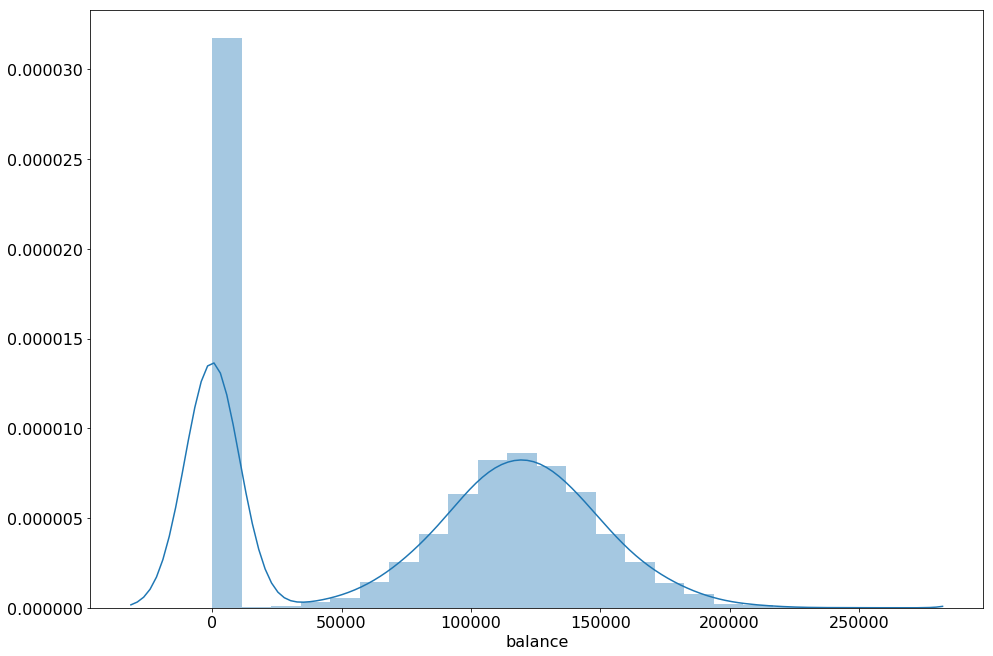

In [24]:
sns.distplot(data['balance'])

Nous observons une forte proportion d'individus ayant un compte bancaire à 0€ le jour de la récupération des informations. Pour autant, cela signifie-t-il qu'il y a eu autant d'individus ayant exactement 0€ sur leur compte bancaire ce jour-là ?

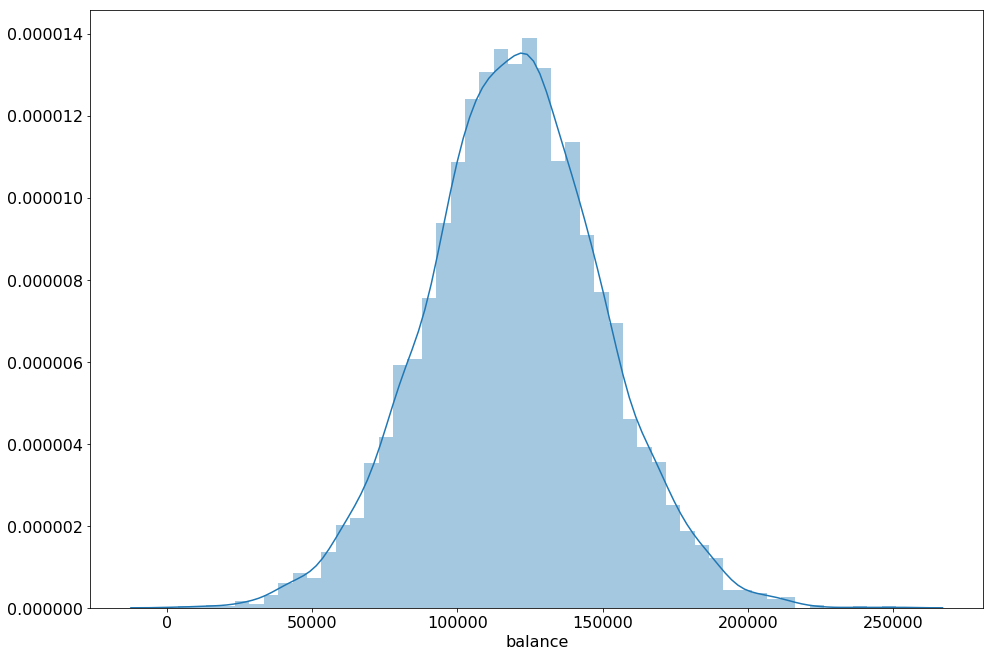

In [25]:
sns.distplot(data['balance'][data['balance'] > 0])

## Analyse multivariée

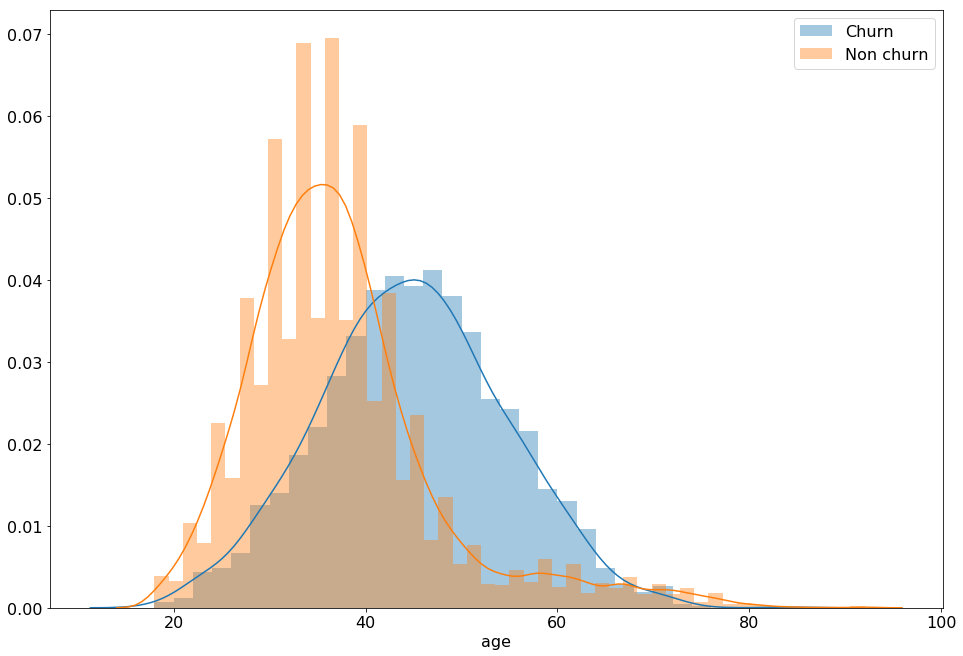

In [26]:
sns.distplot(data.loc[data['exited'] == 1, 'age'], label="Churn")
sns.distplot(data.loc[data['exited'] == 0, 'age'], label="Non churn")
plt.legend()

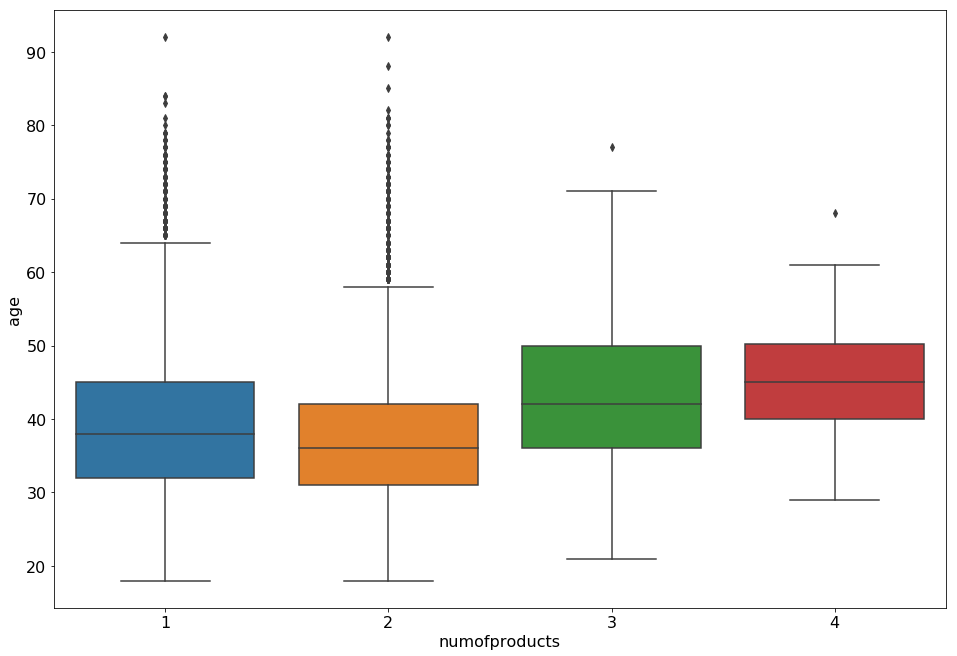

In [27]:
sns.boxplot(x='numofproducts', y='age', data=data)

<center>
  <img width="64" src="https://image.flaticon.com/icons/png/128/148/148769.png" />
  <h1>Que peut-on faire d'une valeur aberrante ?</h1>
</center>

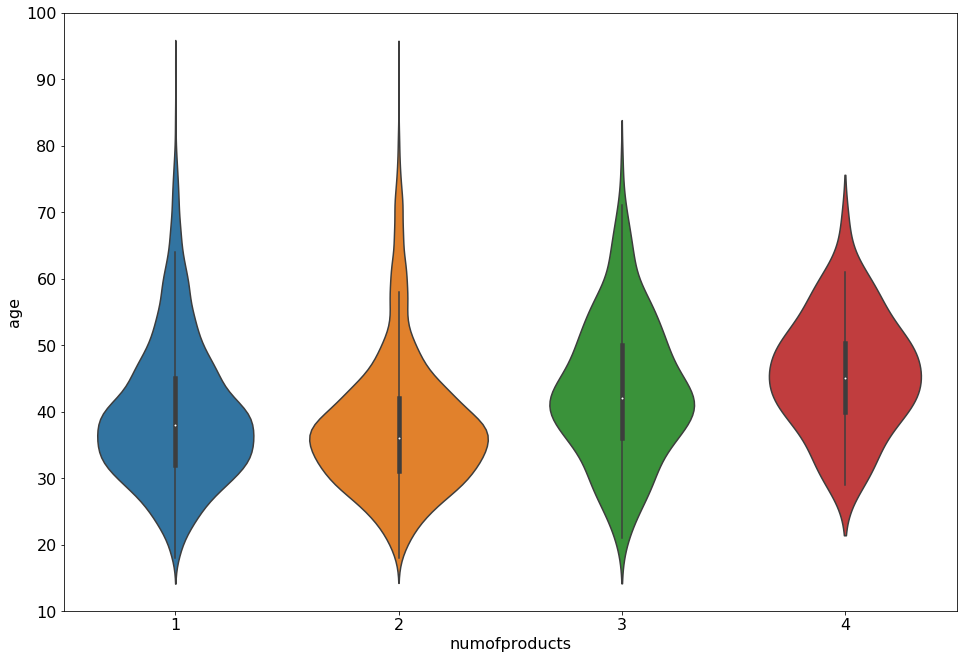

In [28]:
sns.violinplot(x='numofproducts', y='age', data=data)

### Analyse de la variable réponse

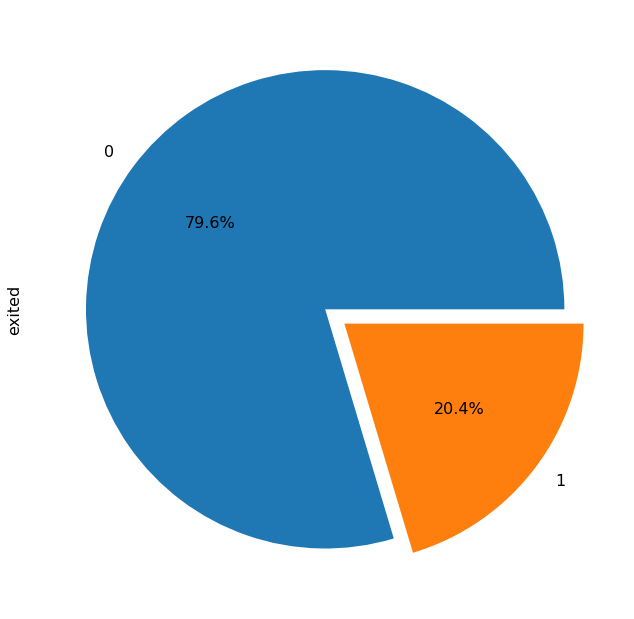

In [32]:
data['exited'].value_counts().plot.pie(autopct=lambda x: '{:2.1f}%'.format(x), explode=[0, 0.1])

<center>
  <img width="64" src="https://image.flaticon.com/icons/png/128/148/148769.png" />
  <h1>Dans ce contexte, que pouvons-nous faire pour agir sur le jeu de données ?</h1>
</center>

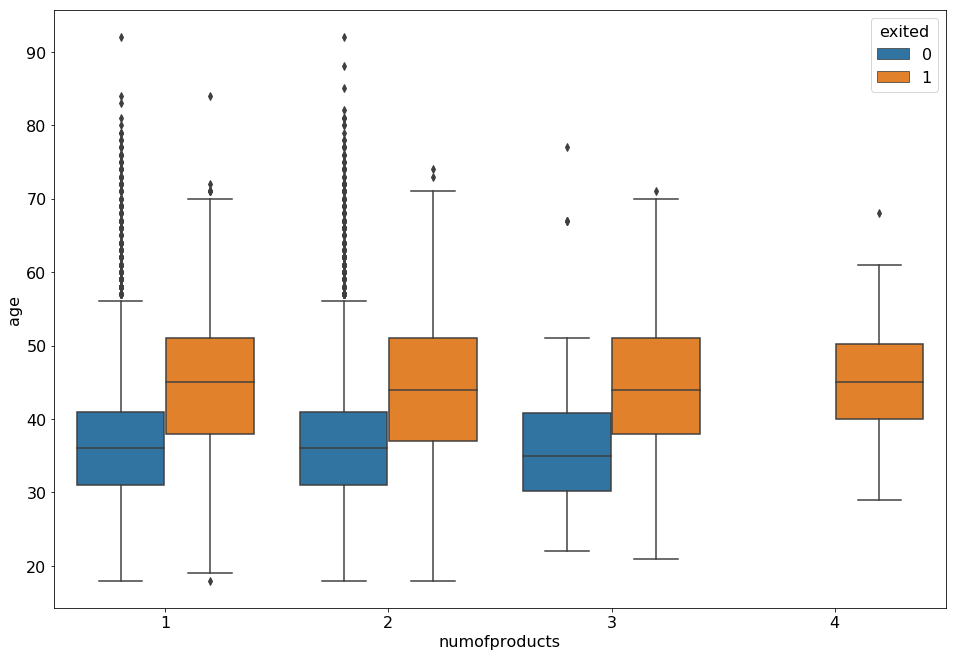

In [33]:
sns.boxplot(x='numofproducts', y='age', data=data, hue="exited")

In [34]:
data[(data['exited'] == 1) & (data['numofproducts'] == 4)].shape

(60, 11)

<center>
  <img width="64" src="https://image.flaticon.com/icons/png/128/148/148769.png" />
  <h1>Quel peut-être le problème pour ces clients ayant résilié avec 4 produits ?</h1>
</center>

In [35]:
churn     = data[data["exited"] == 1]
not_churn = data[data["exited"] == 0]

In [39]:
def plot_pie(column) :
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers" 
                   )


    layout = go.Layout(dict(title = column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)

In [40]:
plot_pie("geography")

In [41]:
plot_pie("numofproducts")

# Nettoyage

In [42]:
cleaned_data = data.copy()
cleaned_data = cleaned_data[~((cleaned_data['exited'] == 1) & (cleaned_data['numofproducts'] == 4))]
cleaned_data.shape

(9940, 11)

# Encodage

<center>
  <img width="64" src="https://image.flaticon.com/icons/png/128/148/148769.png" />
  <h1>Le modèle va-t-il forcément s'améliorer si l'on rajoute plus d'observations ?</h1>
</center>

In [54]:
X = cleaned_data.iloc[:, :-1].copy()
y = cleaned_data['exited']
X.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


## Encodage binaire

In [57]:
X['gender'] = data['gender'].apply(lambda x: 1 if x == "Female" else 0)
X.head()

,creditscore,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,France,Germany,Spain
0,619,1,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,1,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,1,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,1,39,1,0.00,2,0,0,93826.63,1,0,0
4,850,1,43,2,125510.82,1,1,1,79084.10,0,0,1


In [55]:
X = X.join(pd.get_dummies(data['geography']))
X.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,France,Germany,Spain
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,1,0,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,1


In [56]:
del X['geography']
X.head()

,creditscore,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,France,Germany,Spain
0,619,Female,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,Female,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,Female,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,Female,39,1,0.00,2,0,0,93826.63,1,0,0
4,850,Female,43,2,125510.82,1,1,1,79084.10,0,0,1


In [58]:
clean_column_name = []
columns = X.columns
for i in range(len(columns)):
    clean_column_name.append(columns[i].lower())
X.columns = clean_column_name
X.head()

,creditscore,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,france,germany,spain
0,619,1,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,1,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,1,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,1,39,1,0.00,2,0,0,93826.63,1,0,0
4,850,1,43,2,125510.82,1,1,1,79084.10,0,0,1


Avant d'entraîner un modèle, il faut s'assurer que l'on sépare bien le jeu de données en deux ensembles :

- Un ensemble de train
- Un ensemble de test

<center>
  <img width="64" src="https://image.flaticon.com/icons/png/128/148/148769.png" />
  <h1>Selon-vous, pourquoi faut-il séparer le jeu de données en deux et n'entraîner le modèle que sur un seul ?</h1>
</center>

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Modélisation

In [60]:
tree = DecisionTreeClassifier(max_depth=8)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [61]:
from sklearn.metrics import accuracy_score

print("Train :", accuracy_score(y_train, tree.predict(X_train)))
print("Test :", accuracy_score(y_test, tree.predict(X_test)))

Train : 0.8848807128485197
Test : 0.8460764587525151


In [62]:
tree_train_scores = []
tree_test_scores = []
for p in range(2, 15):
  tree = DecisionTreeClassifier(max_depth=p)
  tree.fit(X_train, y_train)
  tree_train_scores.append(accuracy_score(y_train, tree.predict(X_train)) * 100)
  tree_test_scores.append(accuracy_score(y_test, tree.predict(X_test)) * 100)

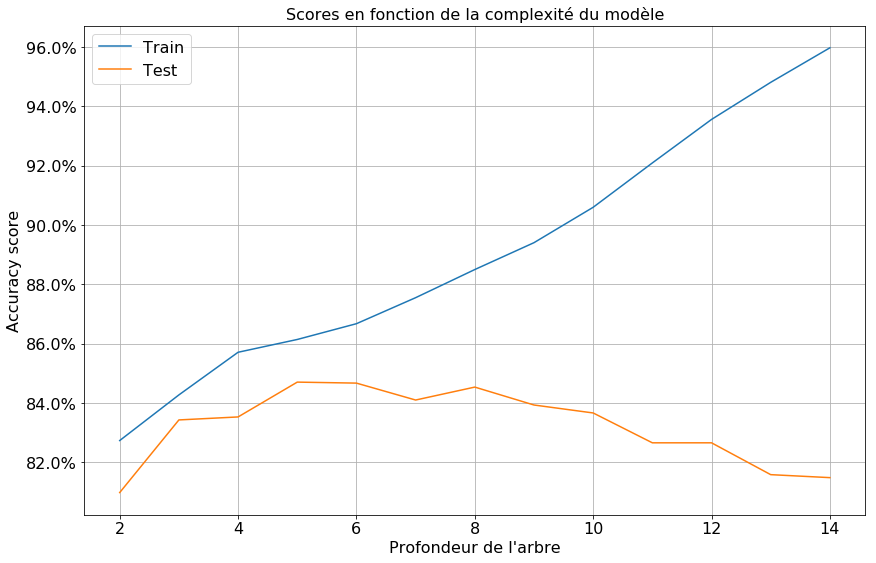

In [64]:
import matplotlib.ticker as mtick

plt.figure(figsize=(14,9))
plt.plot(range(2, 15), tree_train_scores, label="Train")
plt.plot(range(2, 15), tree_test_scores, label="Test")
plt.legend()
plt.title("Scores en fonction de la complexité du modèle")
plt.ylabel("Accuracy score")
plt.xlabel("Profondeur de l'arbre")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
for item in ([plt.gca().title, plt.gca().xaxis.label, plt.gca().yaxis.label] +
             plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    item.set_fontsize(16)
plt.grid()
plt.show()

In [65]:
tree = DecisionTreeClassifier(max_depth=6)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [66]:
features_imp = pd.DataFrame(
    data=np.asarray([X.columns, tree.feature_importances_]).transpose(),
    columns=['Variable', 'Importance'])
features_imp

,Variable,Importance
0,creditscore,0.0165648
1,gender,0
2,age,0.419727
3,tenure,0.00800321
4,balance,0.0897109
5,numofproducts,0.267231
6,hascrcard,0
7,isactivemember,0.14027
8,estimatedsalary,0.0124892
9,france,0


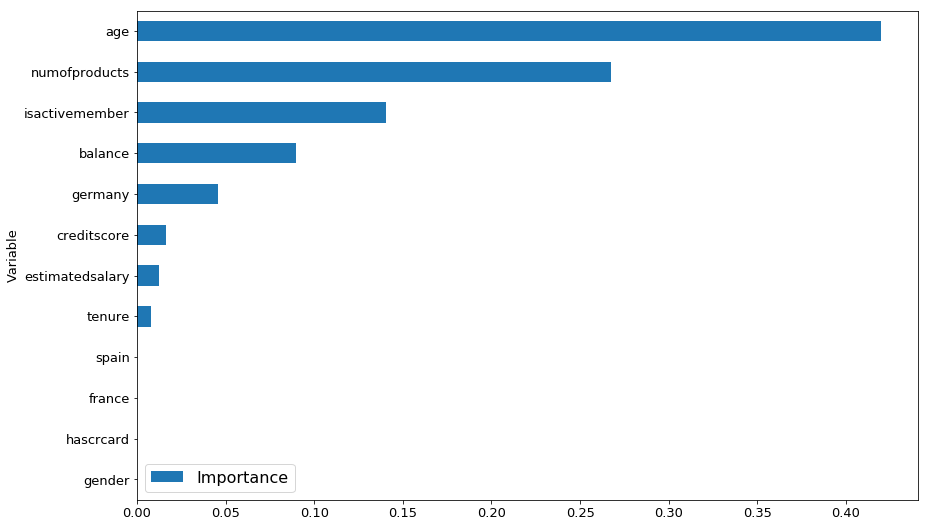

In [67]:
features_imp.set_index("Variable").sort_values(by="Importance").plot.barh(figsize=(14, 9))
for item in ([plt.gca().title, plt.gca().xaxis.label, plt.gca().yaxis.label] +
             plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    item.set_fontsize(13)

In [70]:
!pip install graphviz

In [71]:
import graphviz 
import sklearn.tree

dot_data = sklearn.tree.export_graphviz(tree, out_file=None) 
graph = graphviz.Source(dot_data)
graph

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

# Interprétabilité

In [72]:
shap.initjs()
explainer = shap.TreeExplainer(tree)
shap_values = np.asarray(explainer.shap_values(X_train))[1]

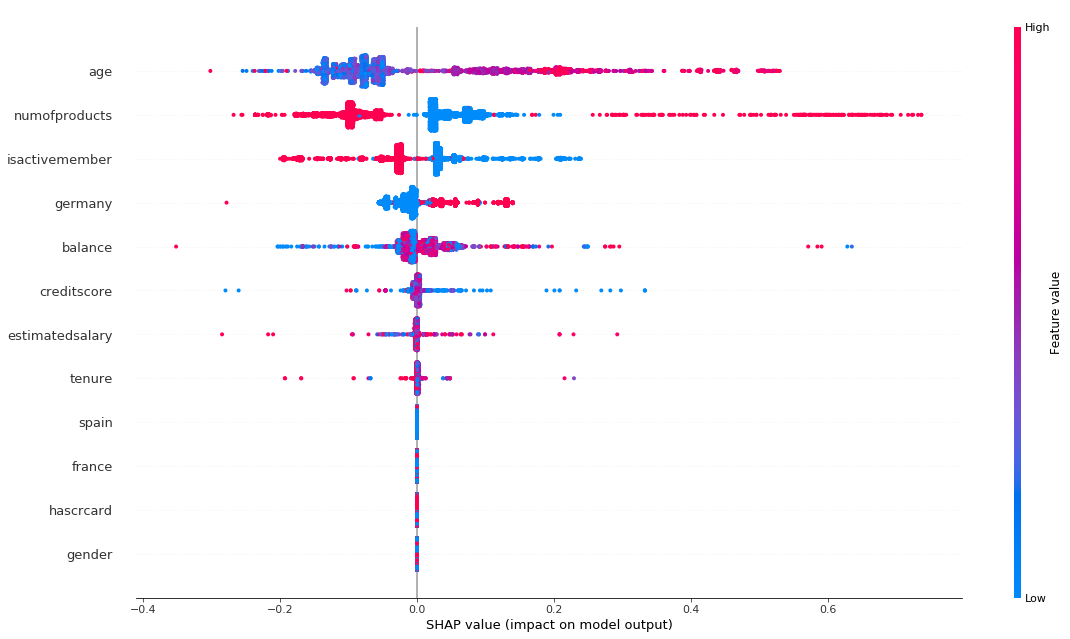

In [73]:
shap.summary_plot(shap_values, X_train, show=False)
plt.gcf().set_size_inches(18.5, 10.5, forward=True)
plt.show()

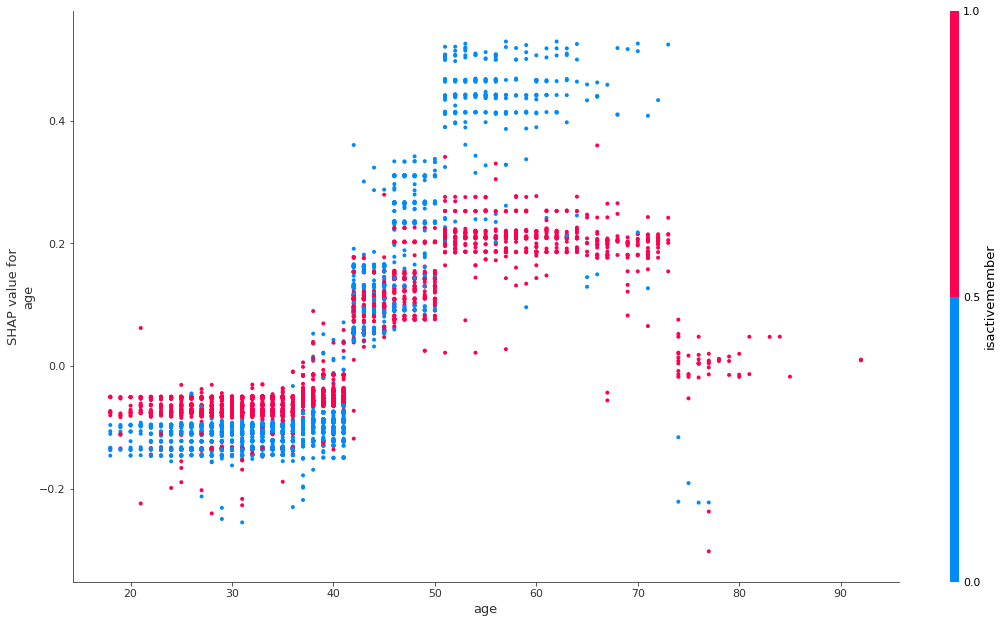

In [74]:
shap.dependence_plot("age", shap_values, X_train, show=False)
plt.gcf().set_size_inches(18.5, 10.5, forward=True)
plt.show()